In [1]:
# General Imports
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Imports for Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Load in the model
model = load_model('vgg_model50.h5')

In [3]:
photo_size = 224
img_size = (photo_size, photo_size)

def preprocess_input(image_path, target_size, rescale_value=1./255):
    # load image
    image = load_img(image_path, target_size=target_size)
    # convert to numpy array
    image = img_to_array(image)
    # rescale pixel values
    image /= rescale_value
    # expand dimension to create a batch of 1 image
    image = np.expand_dims(image, axis=0)
    return image

In [4]:
# find the last layer for analysis
model.summary()

# save this layer
last_conv_layer_name = "block5_conv3"

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# load in the image for analysis
img_path = 'AutismDataset/test/Autistic.29.jpg'

In [6]:
# load in the image for analysis
img_path = 'AutismDataset/customTest/Autistic.0.jpg'

In [7]:
# display in Jupyter Notebook
display(Image(img_path))

FileNotFoundError: No such file or directory: 'AutismDataset/customTest/Autistic.0.jpg'

FileNotFoundError: No such file or directory: 'AutismDataset/customTest/Autistic.0.jpg'

<IPython.core.display.Image object>

In [ ]:
# change image into readable array
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # add a dimension to transform our array into a "batch" of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
# Create the heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # vector where each entry is the mean intensity of the gradient over a specifpipic feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# save the superimposed image to an output layer
def save_and_display_gradcam(img_path, heatmap, alpha=0.8):
    # folder to save the image in
    folder_path = 'output'
        
    timestamp = int(time.time())
    file_name = f'{timestamp}.jpg'

    # load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # save the superimposed image
    array_to_img(superimposed_img).save(os.path.join(folder_path, file_name))

    # display Grad CAM
    display(Image(file_name))

In [ ]:
# prepare image
img_array = preprocess_input(img_path, target_size=img_size)

In [ ]:
# remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

1/1 [==============================] - 1s 523ms/step


In [ ]:
# create the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

In [ ]:
# save superimposed (overlayed) heatmap to folder
save_and_display_gradcam(img_path, heatmap)

FileNotFoundError: No such file or directory: '1695968512.jpg'

FileNotFoundError: No such file or directory: '1695968512.jpg'

<IPython.core.display.Image object>

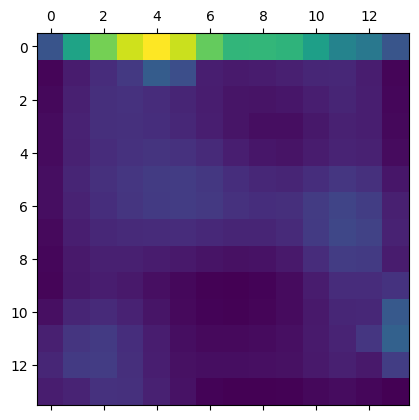

In [ ]:
# display heatmap in new window
plt.matshow(heatmap)
plt.show()